##Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/thesis/OmnieyesDataset/tmp2/omnieyes_signboard_detection_data/Logo_data'

Mounted at /content/drive


##Prerequisities


In [ ]:
%%bash

git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...


In [ ]:
import torch
import numpy as np
import csv
import copy
import pickle
from PIL import Image
from PIL import ImageDraw
import os

import pycocotools
import torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

##Load arranged data

In [ ]:
with open(DATASET_PATH + '/train_arranged.pickle', 'rb') as f:
      train_arranged, train_keys = pickle.load(f)

In [ ]:
with open(DATASET_PATH + '/valid_arranged.pickle', 'rb') as f:
      valid_arranged, valid_keys = pickle.load(f)

In [ ]:
print(train_arranged[train_keys[0]])

[[0, 0, 243, 64], [322, 0, 382, 105], [833, 16, 876, 89], [894, 27, 946, 149], [537, 43, 573, 121], [0, 71, 244, 148], [832, 83, 872, 147], [325, 89, 375, 294], [978, 96, 1214, 248], [483, 97, 521, 153], [905, 143, 952, 264], [0, 148, 290, 227], [931, 194, 976, 259], [0, 228, 311, 291]]


##Form dataset

In [ ]:
class SignboardDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, data_keys, transforms=None):
          self.transforms = transforms
          self.data_file = data_file
          self.data_keys = data_keys


    def __getitem__(self, idx):
          # load images and bounding boxes
          img_path = os.path.join(DATASET_PATH, self.data_keys[idx])
          img = Image.open(img_path).convert("RGB")
          box_list = self.data_file[self.data_keys[idx]]
          boxes = torch.as_tensor(box_list, dtype=torch.float32)

          num_objs = len(box_list)
          # there is only one class
          labels = torch.ones((num_objs,), dtype=torch.int64)
          image_id = torch.tensor([idx])
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

          # suppose all instances are not crowd
          iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          target["image_id"] = image_id
          target["area"] = area
          target["iscrowd"] = iscrowd

          if self.transforms is not None:
              img, target = self.transforms(img, target)

          return img, target


    def __len__(self):
            return len(self.data_keys)

##Form model

In [ ]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
   return model

In [ ]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

##Dataloader and Trasformations

In [ ]:
# use our dataset and defined transformations
dataset = SignboardDataset(data_file=train_arranged, data_keys=train_keys, transforms=get_transform(train=True))
dataset_test = SignboardDataset(data_file=valid_arranged, data_keys=valid_keys, transforms=get_transform(train=False))

# define training and validation data loaders

data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True,
              collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4, pin_memory=True,
         collate_fn=utils.collate_fn)

# print("We have: {} examples, {} are training and {} testing".format(len(dataset) + len(dataset_test), len(dataset), len(dataset_test)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Training settings

###load model

In [ ]:
SAVE_PATH = '/content/drive/My Drive/thesis/SiamNetOmnieyes/models/detection'

epoch = 9

model.load_state_dict(torch.load(SAVE_PATH + '/detction_model_Nesterov_epoch_' + str(epoch) + '.pt'))

###Train model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - signboard and not signboard
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

# let's train it for 20 epochs

optimizer = torch.optim.SGD(params, lr=3e-3,
                            momentum=0.9, weight_decay=0.0005, nesterov=True)

### best setup
# optimizer = torch.optim.SGD(params, lr=5e-4,
#                             momentum=0.9, weight_decay=0.0005, nesterov=True)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-3, eps=1e-5, momentum=0.9)
# optimizer = torch.optim.Adam(params, lr=1e-3, eps=1e-6, weight_decay=0.0005)

# a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)



num_epochs = 20

SAVE_PATH = '/content/drive/My Drive/thesis/SiamNetOmnieyes/models/detection'
MODEL_NAME = '/detction_model_Nesterov_lr_3e-3_step_0.5_'

for epoch in range(num_epochs):

   # train for one epoch, printing every 500 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=250)

   # update the learning rate
  #  lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

   torch.save(model.state_dict(), (SAVE_PATH + MODEL_NAME + '_epoch_' + str(epoch) + '.pt'))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [   0/4146]  eta: 1:03:00  lr: 0.000006  loss: 1.1076 (1.1076)  loss_classifier: 0.8021 (0.8021)  loss_box_reg: 0.0778 (0.0778)  loss_objectness: 0.2007 (0.2007)  loss_rpn_box_reg: 0.0271 (0.0271)  time: 0.9118  data: 0.4349  max mem: 3475
Epoch: [0]  [ 250/4146]  eta: 0:22:47  lr: 0.000755  loss: 0.5414 (0.6023)  loss_classifier: 0.1734 (0.2314)  loss_box_reg: 0.3086 (0.2360)  loss_objectness: 0.0348 (0.1050)  loss_rpn_box_reg: 0.0228 (0.0298)  time: 0.3488  data: 0.0003  max mem: 3739
Epoch: [0]  [ 500/4146]  eta: 0:21:16  lr: 0.001504  loss: 0.4520 (0.5380)  loss_classifier: 0.1580 (0.1991)  loss_box_reg: 0.2457 (0.2398)  loss_objectness: 0.0208 (0.0727)  loss_rpn_box_reg: 0.0137 (0.0264)  time: 0.3499  data: 0.0007  max mem: 3739
Epoch: [0]  [ 750/4146]  eta: 0:19:48  lr: 0.002254  loss: 0.5780 (0.5305)  loss_classifier: 0.2030 (0.1963)  loss_box_reg: 0.3104 (0.2497)  loss_objectness: 0.0321 (0.0587)  loss_rpn_box_reg: 0.0261 (0.0258)  time: 0.3493  data: 0.0002  max me

##Evaluations

###load model

In [ ]:
loaded_model = get_model(num_classes = 2)
SAVE_PATH = '/content/drive/My Drive/thesis/SiamNetOmnieyes/models/detection'
epoch = 10

loaded_model.load_state_dict(torch.load(SAVE_PATH + '/detction_model_epoch_' + str(epoch) + '.pt'))

<All keys matched successfully>

###Predictions

[{'boxes': tensor([[ 297.9262,  108.6776,  343.1027,  245.5167],
        [ 422.5669,  200.5518,  780.1239,  261.1107],
        [ 174.4837,  117.9321,  211.7259,  263.3631],
        [ 521.4761,  213.8775,  554.3672,  249.4985],
        [ 392.4170,  211.8922,  539.7419,  259.2101],
        [ 644.7047,    3.4189,  722.1242,   94.4690],
        [ 250.3582,  151.9471,  285.1335,  226.0897],
        [ 287.0482,  248.2666,  336.9761,  281.6731],
        [ 537.2463,  204.9817,  755.9082,  252.1797],
        [ 941.6662,  102.8542,  978.3206,  203.4655],
        [ 223.9398,  131.4019,  251.3611,  237.8013],
        [ 490.4259,  210.5595,  556.3589,  257.2185],
        [ 181.1802,  120.4037,  206.8769,  224.2535],
        [ 116.2990,  189.8521,  138.6243,  270.6085],
        [ 986.4023,  149.6247, 1275.0491,  236.6994]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9567, 0.9410, 0.6684, 0.5876, 0.5646, 0.3838, 0.3499, 0.2216, 0.2093,
        0.1387, 0.1384

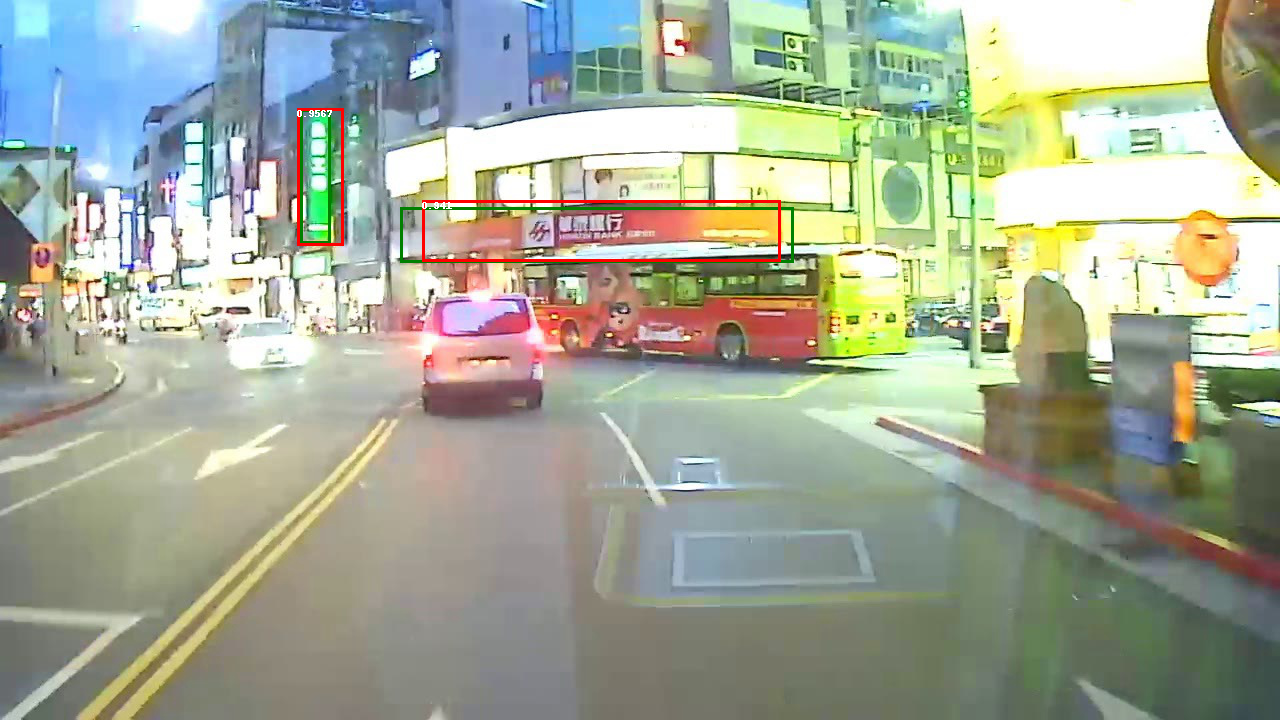

In [ ]:
idx = 500
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
print(prediction)
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.75:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image